In [24]:
query = """
SELECT 
      [FieldZoneID]
      ,PlayTypeID - 1 as PlayTypeID
      ,[ConditionTypeID]
      ,[SpeedID]
      ,[StadiumID]
      ,surf.[SurfaceTypeID]
      ,cast([Shotgun] as int) as Shotgun
      ,cast([AtHome] as int) as AtHome
      ,cast([QBisRookie] as int) as QBisRookie
      ,[Down]
      ,CASE
            WHEN yardsToGo < 11 THEN 1
            WHEN yardsToGo < 15 THEN 2
            WHEN yardsToGo < 20 THEN 3
            WHEN yardsToGo < 30 THEN 4
            ELSE 5
       END as yardsToGoBucket
      ,[TimeoutsLeft]
      ,qsb.SecondsBucketID as SecondsInQuarterBucketID
      ,[SecondsLeftInQuarter]/60 as [MinutesLeftInQuarter]
      ,hsb.SecondsBucketID as SecondsInHalfBucketID
      ,gsb.SecondsBucketID as SecondsInGameBucketID
      ,[GameQuarter]
      ,opb.PointsBucketID as OffensePointsBucketID
      ,dpb.PointsBucketID as DefensePointsBucketID
      ,pdb.PointsBucketID as PointsDifferenceBucketID
      ,p.OffenseWinLossRatio
      ,p.DefenseWinLossRatio
  FROM [NFL_Prediction].[nfl].[f_play] p
  INNER JOIN [NFL_Prediction].[nfl].[d_team] o on p.OffenseID = o.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_team] d on p.DefenceID = d.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_weather] w on p.WeatherID = w.WeatherID
  INNER JOIN [NFL_Prediction].[nfl].[d_surface] surf on p.SurfaceID = surf.SurfaceID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] qsb on p.SecondsLeftInQuarterBucketID = qsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] hsb on p.SecondsLeftInHalfBucketID = hsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] gsb on p.SecondsLeftInHalfBucketID = gsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] opb on p.OffensePointsBucketID = opb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] dpb on p.DefensePointsBucketID = dpb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] pdb on p.PointsDifferenceBucketID = pdb.PointsBucketID
  where MainPlayerID is not null
"""

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [26]:
import pyodbc
sql_conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=localhost\\uni;DATABASE=NFL_Prediction;Trusted_Connection=yes')
df = pd.read_sql(query, sql_conn)

In [27]:
features = df.drop('PlayTypeID', axis=1).columns.values.tolist()
y=['PlayTypeID']
x=[i for i in features if i not in y]
x

['FieldZoneID',
 'ConditionTypeID',
 'SpeedID',
 'StadiumID',
 'SurfaceTypeID',
 'Shotgun',
 'AtHome',
 'QBisRookie',
 'Down',
 'yardsToGoBucket',
 'TimeoutsLeft',
 'SecondsInQuarterBucketID',
 'MinutesLeftInQuarter',
 'SecondsInHalfBucketID',
 'SecondsInGameBucketID',
 'GameQuarter',
 'OffensePointsBucketID',
 'DefensePointsBucketID',
 'PointsDifferenceBucketID',
 'OffenseWinLossRatio',
 'DefenseWinLossRatio']

In [28]:
df.count()

FieldZoneID                 639914
PlayTypeID                  639914
ConditionTypeID             639914
SpeedID                     639914
StadiumID                   639914
SurfaceTypeID               639914
Shotgun                     639914
AtHome                      639914
QBisRookie                  639914
Down                        639914
yardsToGoBucket             639914
TimeoutsLeft                639914
SecondsInQuarterBucketID    639914
MinutesLeftInQuarter        639914
SecondsInHalfBucketID       639914
SecondsInGameBucketID       639914
GameQuarter                 639914
OffensePointsBucketID       639914
DefensePointsBucketID       639914
PointsDifferenceBucketID    639914
OffenseWinLossRatio         639914
DefenseWinLossRatio         639914
dtype: int64

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [30]:
logreg = LogisticRegression()

In [31]:
# drop the prediction column
play_df = df.drop(['PlayTypeID'], axis=1)
play_df.head(3)

,FieldZoneID,ConditionTypeID,SpeedID,StadiumID,SurfaceTypeID,Shotgun,AtHome,QBisRookie,Down,yardsToGoBucket,...,SecondsInQuarterBucketID,MinutesLeftInQuarter,SecondsInHalfBucketID,SecondsInGameBucketID,GameQuarter,OffensePointsBucketID,DefensePointsBucketID,PointsDifferenceBucketID,OffenseWinLossRatio,DefenseWinLossRatio
0,3,6,2,61,1,0,1,0,2,1,...,2,8,5,5,3,6,7,4,0,0
1,1,6,2,61,1,0,0,0,1,1,...,2,7,5,5,3,7,6,7,0,0
2,1,6,2,61,1,0,0,0,2,1,...,2,7,5,5,3,7,6,7,0,0


In [32]:
# Split out the prediction column into separate dataframe
predict_df = df.filter(['PlayTypeID'], axis=1)
predict_df.PlayTypeID.unique()

array([0, 1], dtype=int64)

In [33]:
rfe = RFE(logreg, 20)
rfe = rfe.fit(play_df, predict_df.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Use all columns apart from StadiumID!

In [34]:
play_df = play_df.drop(['SpeedID'], axis=1)

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(predict_df, play_df)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.575607
         Iterations: 35


C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                    Results: Logit
Model:                      Logit                  Pseudo R-squared:       0.158      
Dependent Variable:         PlayTypeID             AIC:                    736715.5496
Date:                       2020-01-03 13:59       BIC:                    736931.5623
No. Observations:           639914                 Log-Likelihood:         -3.6834e+05
Df Model:                   18                     LL-Null:                -4.3745e+05
Df Residuals:               639895                 LLR p-value:            0.0000     
Converged:                  0.0000                 Scale:                  1.0000     
No. Iterations:             35.0000                                                   
--------------------------------------------------------------------------------------
                          Coef.    Std.Err.      z     P>|z|     [0.025       0.975]  
-------------------------------------------------------------------------------

In [36]:
import statsmodels.api as sm
logit_model=sm.Logit(predict_df, play_df.drop(['QBisRookie', 'SecondsInHalfBucketID', 'SecondsInGameBucketID', 'StadiumID'], axis=1))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.596028
         Iterations 5
                              Results: Logit
Model:                  Logit              Pseudo R-squared:   0.128      
Dependent Variable:     PlayTypeID         AIC:                762845.2681
Date:                   2020-01-03 14:00   BIC:                763027.1735
No. Observations:       639914             Log-Likelihood:     -3.8141e+05
Df Model:               15                 LL-Null:            -4.3745e+05
Df Residuals:           639898             LLR p-value:        0.0000     
Converged:              1.0000             Scale:              1.0000     
No. Iterations:         5.0000                                            
--------------------------------------------------------------------------
                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
FieldZoneID               0.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(play_df, predict_df, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)*100))

Accuracy of logistic regression classifier on test set: 68.71


[[73824 35467]
 [24611 58073]]


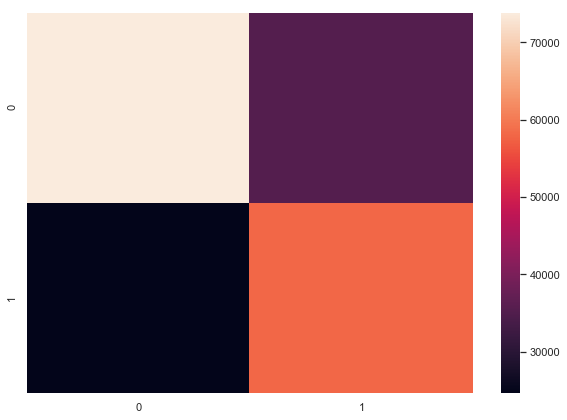

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix, annot=False)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71    109291
           1       0.62      0.70      0.66     82684

    accuracy                           0.69    191975
   macro avg       0.69      0.69      0.68    191975
weighted avg       0.69      0.69      0.69    191975



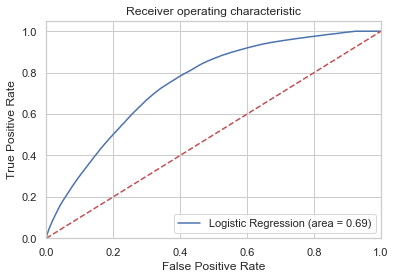

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [42]:
logreg.predict_proba(X_test)[:,1]

array([0.5921894 , 0.38941958, 0.19689679, ..., 0.66769668, 0.47419758,
       0.33597825])

In [43]:
y_pred_df = pd.DataFrame(y_pred)
y_test_np = y_test.to_numpy()
y_pred_np = y_pred_df.to_numpy()
check_prediction_df = pd.DataFrame(np.concatenate((y_test_np, y_pred_np), axis=1))
check_prediction_df[0] = check_prediction_df[0] + 1
check_prediction_df[1] = check_prediction_df[1] + 1
check_prediction_df['correct'] = np.where(check_prediction_df[0] == check_prediction_df[1], 'yes', 'no')

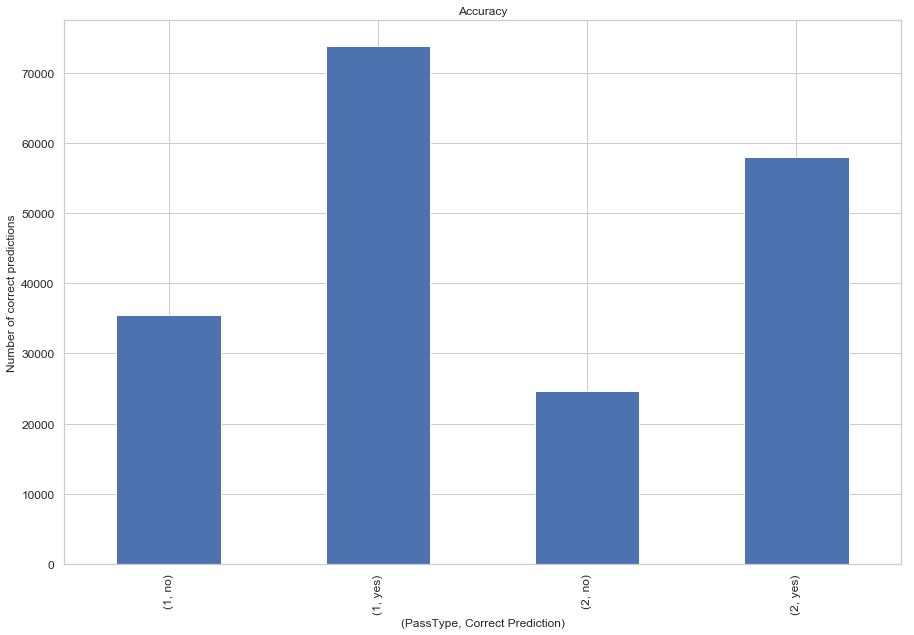

In [44]:
agg_df = check_prediction_df.groupby([0,'correct']).count()
ax = agg_df.plot(kind='bar', title ="Accuracy", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("(PassType, Correct Prediction)", fontsize=12)
ax.set_ylabel("Number of correct predictions", fontsize=12)
plt.show()